In [6]:
install.packages("pacman")
pacman::p_load(class, datasets, caret, Stat2Data, ggplot2, randomForest, kernlab)
remotes::install_github("allisonhorst/palmerpenguins")
library(palmerpenguins)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


kernlab installed

Skipping install of 'palmerpenguins' from a github remote, the SHA1 (c19a9044) has not changed since last install.
  Use `force = TRUE` to force installation



In [2]:
remove_NA <- function(data) {
  data <- data[complete.cases(data), ]
  return(data)
}

In [3]:
remove_columns <- function(data, columns_to_remove) {
  data <- data[, !(names(data) %in% columns_to_remove)]
  return(data)
}

In [4]:
compare_algorithms <- function(data, label, dataset_name) {
  set.seed(100)

  TrainingIndex <- createDataPartition(data[[label]], p = 0.8, list = FALSE)
  TrainingSet <- data[TrainingIndex,]
  TestingSet <- data[-TrainingIndex,]

  Formula <- as.formula(paste(label, "~ ."))

  ## 1) 1-NN algorithm
  cat("\n1-NN:")
  Model_1nn <- train(Formula, data = TrainingSet,
      method = "knn",
      trControl = trainControl(method = "none"),
      tuneGrid = data.frame(k = 1)
  )

  # 1-NN predictions
  Model_1nn.training <- predict(Model_1nn, TrainingSet)
  Model_1nn.testing <- predict(Model_1nn, TestingSet)

  Model_1nn.training.confusion <- confusionMatrix(Model_1nn.training, as.factor(TrainingSet[[label]]))
  Model_1nn.testing.confusion <- confusionMatrix(Model_1nn.testing, as.factor(TestingSet[[label]]))

  # 1-NN model accuracy
  print("1-NN Testing Set Accuracy:")
  print(Model_1nn.testing.confusion$overall["Accuracy"])

  ## 2) k-NN algorithm
  cat("\nk-NN:")

  k_to_try = 1:100
  acc_k = rep(x = 0, times = length(k_to_try))
  for(i in seq_along(k_to_try)) {
    Model_knn <- train(Formula, data = TrainingSet,
        method = "knn",
        trControl = trainControl(method = "none"),
        tuneGrid = data.frame(k = i)
    )

    # k-NN cross-validation model
    Model_knn.cv <- train(Formula, data = TrainingSet,
        method = "knn",
        trControl = trainControl(method = "cv", number = 10),
        tuneGrid = data.frame(k = i)
    )

    # k-NN model predictions
    Model_knn.training <- predict(Model_knn, TrainingSet)
    Model_knn.testing <- predict(Model_knn, TestingSet)
    Model_knn.cv <- predict(Model_knn.cv, TrainingSet)

    Model_knn.training.confusion <- confusionMatrix(Model_knn.training, as.factor(TrainingSet[[label]]))
    Model_knn.testing.confusion <- confusionMatrix(Model_knn.testing, as.factor(TestingSet[[label]]))
    Model_knn.cv.training.confusion <- confusionMatrix(Model_knn.cv, as.factor(TrainingSet[[label]]))

    acc_k[i] = Model_knn.testing.confusion$overall["Accuracy"]
  }

  # k-NN accuracy comparison - comment out this section to not override other plots
  plot(acc_k, type = "b", col = "dodgerblue", cex = 1, pch = 20,
       xlab = "k, number of neighbors", ylab = "classification accuracy",
       main = paste("K-NN: Accuracy vs Neighbors ", dataset_name))

  abline(v = which(acc_k == max(acc_k)), col = "darkorange", lwd = 1.5)
  abline(h = max(acc_k), col = "grey", lty = 2)
  abline(h = mean(TestingSet == "No"), col = "grey", lty = 2)

  print(paste("Maximal k-NN accuracy ", max(acc_k)))

  ## 3) SVM algorithm
  cat("\nSVM:")
  Model_svm <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "none"),
      tuneGrid = data.frame(degree = 1, scale = 1, C = 1)
  )

  Model_svm_2 <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "none"),
      tuneGrid = data.frame(degree = 2, scale = 2, C = 2)
  )

  Model_svm_3 <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "none"),
      tuneGrid = data.frame(degree = 3, scale = 3, C = 3)
  )

  # SVM cross-validation model
  Model_svm.cv <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "cv", number = 10),
      tuneGrid = data.frame(degree = 1, scale = 1, C = 1)
  )

  Model_svm_2.cv <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "cv", number = 10),
      tuneGrid = data.frame(degree = 2, scale = 2, C = 2)
  )

  Model_svm_3.cv <- train(Formula, data = TrainingSet,
      method = "svmPoly",
      na.action = na.omit,
      preProcess = c("scale", "center"),
      trControl = trainControl(method = "cv", number = 10),
      tuneGrid = data.frame(degree = 3, scale = 3, C = 3)
  )

  # SVM model predictions
  Model_svm.training <- predict(Model_svm, TrainingSet)
  Model_svm.testing <- predict(Model_svm, TestingSet)
  Model_svm.cv <- predict(Model_svm.cv, TrainingSet)

  Model_svm.training.confusion <- confusionMatrix(Model_svm.training, as.factor(TrainingSet[[label]]))
  Model_svm.testing.confusion <- confusionMatrix(Model_svm.testing, as.factor(TestingSet[[label]]))
  Model_svm.cv.confusion <- confusionMatrix(Model_svm.cv, as.factor(TrainingSet[[label]]))

  Model_svm_2.training <- predict(Model_svm_2, TrainingSet)
  Model_svm_2.testing <- predict(Model_svm_2, TestingSet)
  Model_svm_2.cv <- predict(Model_svm_2.cv, TrainingSet)

  Model_svm_2.training.confusion <- confusionMatrix(Model_svm_2.training, as.factor(TrainingSet[[label]]))
  Model_svm_2.testing.confusion <- confusionMatrix(Model_svm_2.testing, as.factor(TestingSet[[label]]))
  Model_svm_2.cv.confusion <- confusionMatrix(Model_svm_2.cv, as.factor(TrainingSet[[label]]))

  Model_svm_3.training <- predict(Model_svm_3, TrainingSet)
  Model_svm_3.testing <- predict(Model_svm_3, TestingSet)
  Model_svm_3.cv <- predict(Model_svm_3.cv, TrainingSet)

  Model_svm_3.training.confusion <- confusionMatrix(Model_svm_3.training, as.factor(TrainingSet[[label]]))
  Model_svm_3.testing.confusion <- confusionMatrix(Model_svm_3.testing, as.factor(TestingSet[[label]]))
  Model_svm_3.cv.confusion <- confusionMatrix(Model_svm_3.cv, as.factor(TrainingSet[[label]]))

  # SVM accuracy comparison
  accuracies_svm <- c(Model_svm.testing.confusion$overall["Accuracy"],
      Model_svm_2.testing.confusion$overall["Accuracy"],
      Model_svm_3.testing.confusion$overall["Accuracy"])

  print("SVM Testing sets accuracies:")
  print(accuracies_svm)

  models_svm <- c("Model_svm", "Model_svm_2", "Model_svm_3")
  data_svm <- data.frame(Model = factor(models_svm, levels = models_svm), Accuracy = accuracies_svm)

  ggplot(data_svm, aes(x = Model, y = Accuracy, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = paste("Comparison of SVM Accuracies ", dataset_name),
         y = "Accuracy",
         x = "Models") + theme_minimal()

  ## 4) Random Forest algorithm
  cat("\nRandom Forest:")

  Model_RF <- randomForest(Formula, data = TrainingSet)

  # Random Forest predictions
  Model_RF.training <- predict(Model_RF, newdata = TrainingSet)
  Model_RF.testing <- predict(Model_RF, newdata = TestingSet)

  Model_RF.training.confusion <- confusionMatrix(Model_RF.training, as.factor(TrainingSet[[label]]))
  Model_RF.testing.confusion <- confusionMatrix(Model_RF.testing, as.factor(TestingSet[[label]]))

  # Random Forest model accuracy
  print("Random Forest Testing Set Accuracy:")
  print(Model_RF.testing.confusion$overall["Accuracy"])

  ## overall accuracy comparison
  accuracies <- c(Model_1nn.testing.confusion$overall["Accuracy"],
                  max(acc_k),
                  max(accuracies_svm),
                  Model_RF.testing.confusion$overall["Accuracy"])

  models <- c("Model_1nn", "Model_knn", "Model_svm", "Model_RF")
  data <- data.frame(Model = factor(models, levels = models), Accuracy = accuracies)

  ggplot(data, aes(x = Model, y = Accuracy, fill = Model)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(title = paste("Comparison of Model Accuracies ", dataset_name),
         y = "Accuracy",
         x = "Models") +
    theme_minimal()

  return(accuracies)
}


1-NN:[1] "1-NN Testing Set Accuracy:"
 Accuracy 
0.9333333 

k-NN:[1] "Maximal k-NN accuracy  0.933333333333333"

SVM:[1] "SVM Testing sets accuracies:"
 Accuracy  Accuracy  Accuracy 
0.9666667 0.9666667 0.9333333 

Random Forest:[1] "Random Forest Testing Set Accuracy:"
Accuracy 
     0.9 


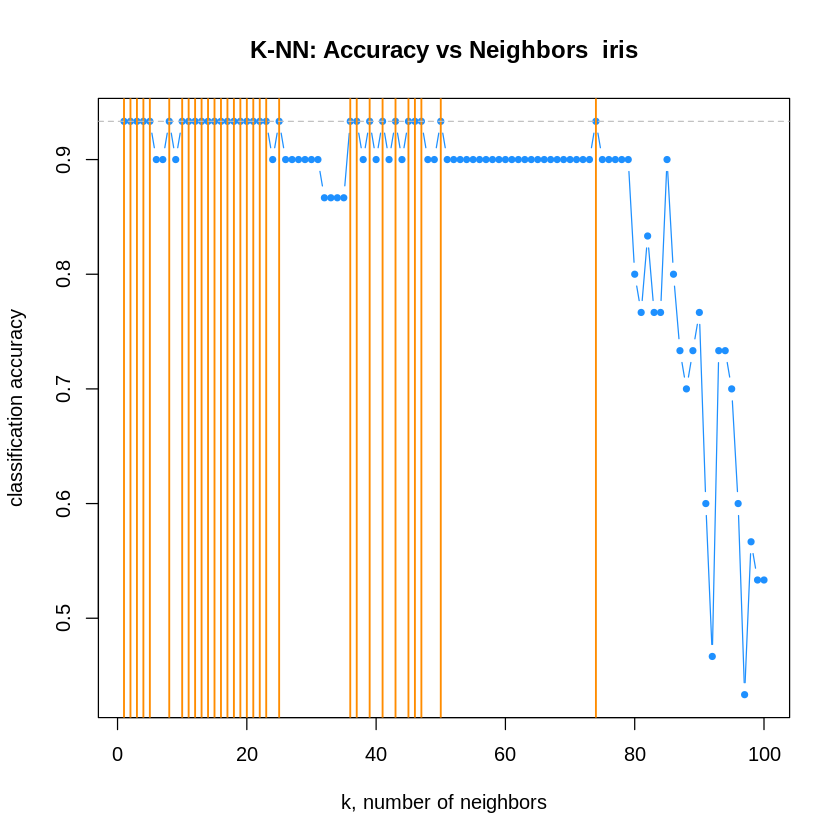

In [7]:
data(iris)
acc_iris <- compare_algorithms(iris, "Species", "iris")


1-NN:[1] "1-NN Testing Set Accuracy:"
 Accuracy 
0.8615385 

k-NN:[1] "Maximal k-NN accuracy  0.861538461538462"

SVM:[1] "SVM Testing sets accuracies:"
 Accuracy  Accuracy  Accuracy 
0.9846154 0.9692308 0.9692308 

Random Forest:[1] "Random Forest Testing Set Accuracy:"
Accuracy 
       1 


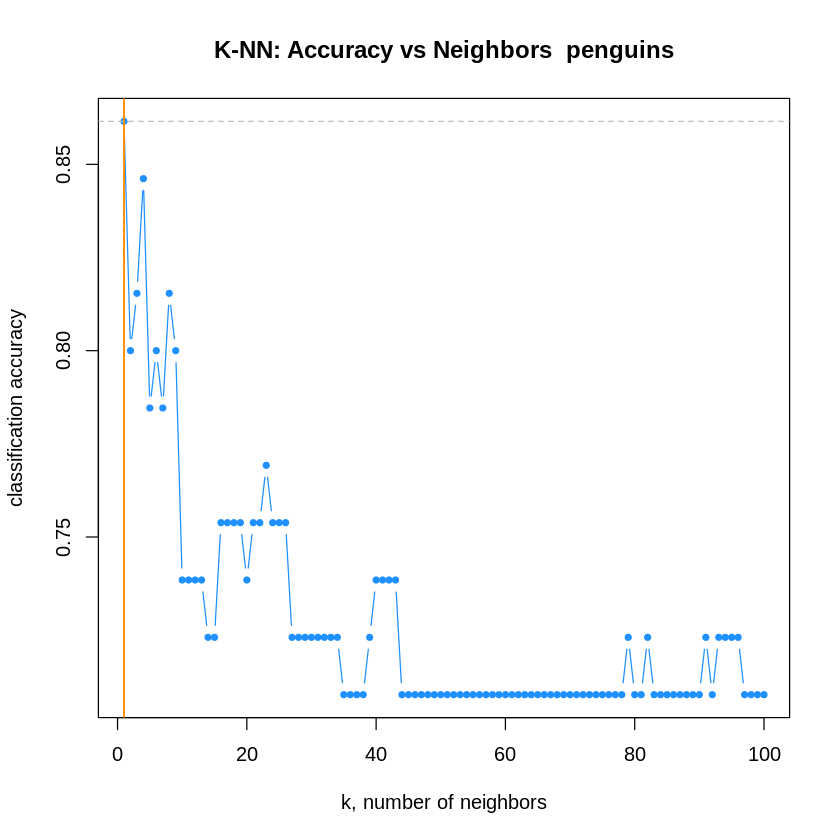

In [8]:
data(penguins)
penguins <- remove_NA(penguins)
acc_penguins <- compare_algorithms(penguins, "species", "penguins")


1-NN:[1] "1-NN Testing Set Accuracy:"
 Accuracy 
0.9717514 

k-NN:[1] "Maximal k-NN accuracy  0.971751412429379"

SVM:[1] "SVM Testing sets accuracies:"
 Accuracy  Accuracy  Accuracy 
0.9661017 0.9717514 0.9717514 

Random Forest:[1] "Random Forest Testing Set Accuracy:"
 Accuracy 
0.9717514 


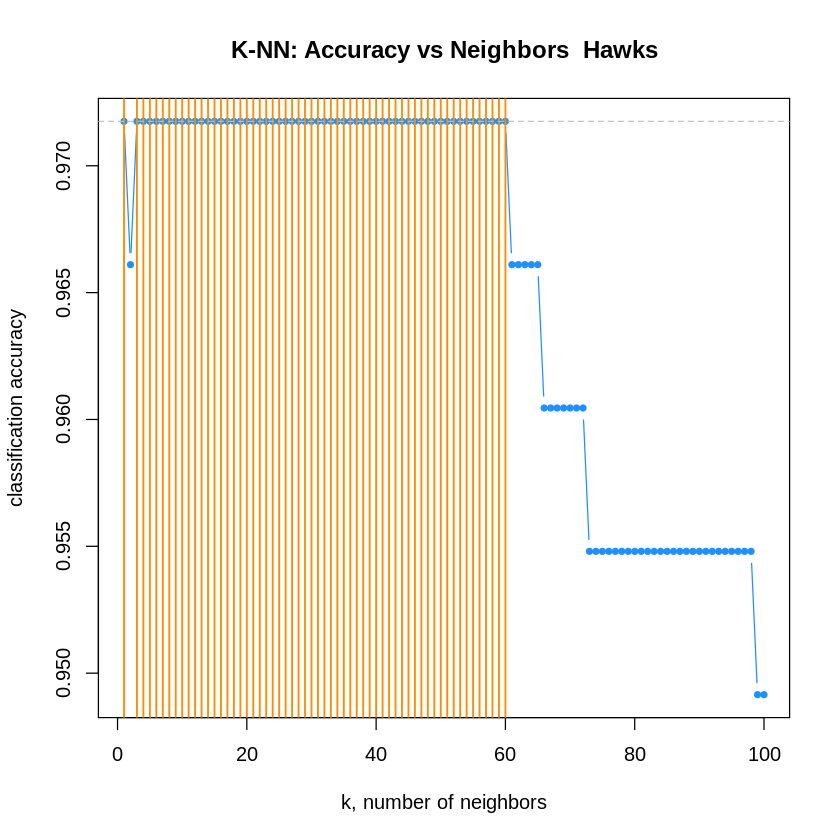

In [9]:
data(Hawks)
columns_to_remove <- c("ReleaseTime", "CaptureTime", "Sex", "Year", "BandNumber", "StandardTail", "Tarsus", "WingPitFat", "KeelFat", "Crop")
Hawks <- remove_columns(Hawks, columns_to_remove)
Hawks <- remove_NA(Hawks)
acc_Hawks <- compare_algorithms(Hawks, "Species", "Hawks")

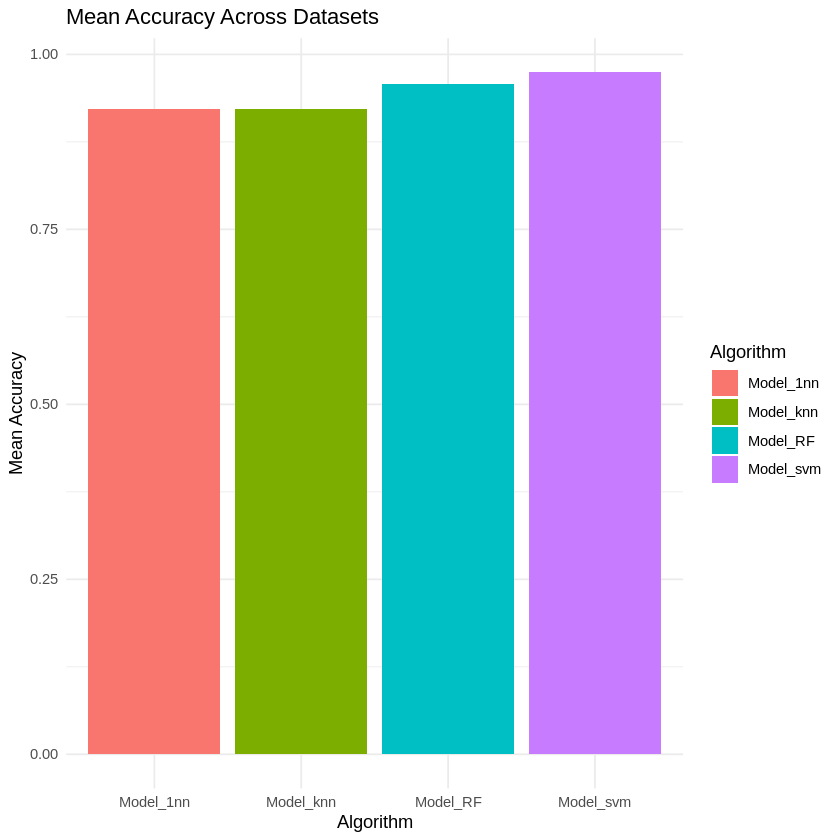

In [10]:
all_accuracies <- rbind(acc_iris, acc_penguins, acc_Hawks)
colnames(all_accuracies) <- c("Model_1nn", "Model_knn", "Model_svm", "Model_RF")

df_all_accuracies <- data.frame(all_accuracies)
mean_accuracies <- colMeans(df_all_accuracies, na.rm = TRUE)

df_mean_accuracies <- data.frame(Algorithm = names(mean_accuracies), Mean_Accuracy = mean_accuracies)

ggplot(df_mean_accuracies, aes(x = Algorithm, y = Mean_Accuracy, fill = Algorithm)) +
  geom_bar(stat = "identity") +
  labs(title = "Mean Accuracy Across Datasets",
       x = "Algorithm",
       y = "Mean Accuracy") +
  theme_minimal()